In [1]:
include("../src.jl")

itproot

(chapters:integration:newton-cotes)=
# Формулы Ньютона-Котса

Рассмотрим задачу приближения интеграла
```{math}
I = \int\limits_{0}^{1} f(x) \diff x
```

Очевидный способ -- ввести равномерную сетку $\{x_i = \frac{i-1}{N-1}, i = 1, \dots, N\}$ или $\{x_i = \frac{i - 1/2}{N}, i = 1, \dots, N\}$, вычислить полиномиальную интерполяцию подынтегральной функции по значениям в этих точках и взять значение интеграла от полиномиальной интерполяции за приближение к интегралу $I$.

```{index} формула; Ньютона-Котса
```
Получаемые таким образом квадратурные формулы называются **формулами Ньютона-Котса**. Два выбора узлов интерполяции соответствуют *закрытым* (концы отрезка входят в множество узлов) и *открытым* (концы отрезка не входят во множество узлов) формулам.

Веса формул Ньютона-Котса определяются из условия, что формула с $N$ узлами должна давать точное значение интеграла для всех многочленов степени ниже $N$, в частности, для "чистых" степеней $x^p$:

```{math}
\sum\limits_{i=1}^{N} w_i x_i^p = \int\limits_{0}^{1} x^p \diff x = \frac{1}{p + 1} \quad\forall p \in \{0, \dots, N-1\}
```

Это условие дает линейную систему:

```{math}
:label: NewtonCotesGeneral

\left(
\begin{array}{cccc}
 1  &  1  & \dots & 1 \\
x_1 & x_2 & \dots & x_N \\
x_1^2 & x_2^2 & \dots & x_N^2 \\
\vdots & \vdots&  & \vdots\\
x_1^{N-1} & x_2^{N-1} & \dots & x_N^{N-1}
\end{array}
\right) 
\left(
\begin{array}{c}
w_1 \\
w_2 \\
w_3 \\
\vdots \\
w_N
\end{array}
\right) = 
\left(
\begin{array}{c}
1 \\
1 / 2 \\
1 / 3 \\
\vdots \\
1 / N
\end{array}
\right)
```

```{index} квадратура; алгебраический порядок
```
Говорят, что квадратурная формула имеет **алгебраический порядок** $p$, если она точна для всех многочленов степени $p$ и меньше. Из формулы для вычисления весов видно, что квадратура Ньютона-Котса с $N$ узлами имеет алгебраический порядок как минимум $N-1$. Однако из симметрии задачи легко показать, что веса удовлетворяют условию $w_i = w_{N-i+1}$. Это приводит к тому, что формулы с нечетным $N$ приобретают "дополнительный" порядок точности и имеют алгебраический порядок $N$ (это легко видеть, заметив, что для отрезка $[-1; 1]$ квадратурная формула дает ноль для нечётных функций, т.е. интегрирует их точно, а функция $f(x) = x^N$ -- нечётная при нечётном $N$). 

Кажется, что точность формул Ньютона-Котса растет с повышением порядка, но при расчетах с конечной точностью это не так. При повышении степени в этих формулах появляются отрицательные веса, что приводит к численной неустойчивости. Поэтому в основном применяются формулы Ньютона-Котса низких порядков. В этом случае лучше брать закрытые формулы, т.к. конечная точка одного подотрезка является начальной точкой следующего, что экономит одно вычисление подынтегральной функции по сравнению с открытыми формулами того же порядка точности. Тем не менее, если на одном из концов отрезка функция имеет особенность, применение открытых формул позволяет избежать её вычисления в этой точке.

Ниже приведены некоторые составные квадратурные формулы Ньютона-Котса.

## Формула прямоугольников

Для открытой формулы с 1 узлом (т.е. подынтегральная функция приближается константой):

```{index} формула; средних прямоугольников
```
```{margin}
Существуют также формулы левых и правых прямоугольников, но у них хуже точность.
```
```{math}
\int_{x_{i-1}}^{x_i} f(x)\diff x \approx (x_i - x_{i-1})f(x_{i-1/2}),\quad x_{i-1/2} = \frac{x_{i-1} + x_i}{2}.
```

Эту формулу называют формулой **средних прямоугольников** (*midpoint rule*).

**Составная формула прямоугольников** имеет вид

```{math}
\int_a^b f(x)\diff x \approx \sum_{i=1}^n h \cdot f(x_i),\quad x_i = a + (i - 1/2)h, \quad h = \frac{b - a}{n}.
```

```{margin}
`start:step:stop` означает диапазон точек с шагом `step`, начинающийся со `start`, последнее значение в котором меньше или равно `stop`.

`sum(f, x)` вычисляет сумму значений функции `f` на массиве `x`.
```
:::{proof:function} midpoint

**Формула прямоугольников**

```julia
"""
Вычисляет по формуле прямоугольников интеграл ∫`f`dx на отрезке [`a`, `b`]
с равномерной сеткой из `n` интервалов.
Возвращает значение интеграла, узлы и значения функции в узлах.
"""
function midpoint(f, a, b, n)
    h = (b - a) / n
    x = range(a + h/2, b; step=h)
    int = h * sum(f, x)
    return int
end
```
:::

:::{proof:demo}
:::

```{raw} html
<div class="demo">
```

Ниже представлены графики численного интеграла

```{math}
\int_0^3 x e^{\sin 2x}
```

для разного числа точек.

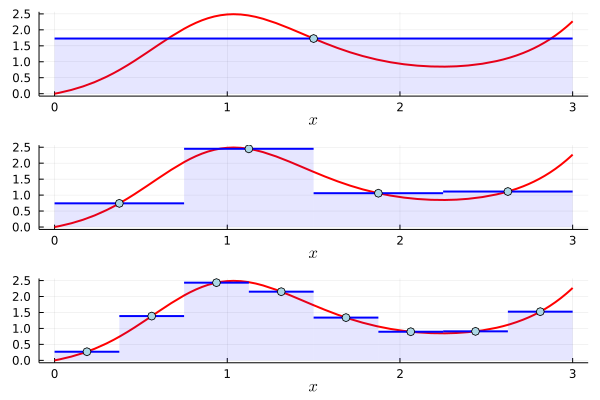

In [2]:
foo(x) = x * exp(sin(2x))
plt = plot(layout=(3,1), leg=:none, xlabel=L"x")
for (i, n) in enumerate((1, 4, 8))
    plot!(foo, 0, 3; subplot=i, linewidth=2, linecolor=:red)
    
    h = 3/n
    x = [h/2 + i * h for i in 0:n-1]
    y = foo.(x)
    for (px, py) in zip(x, y)
        h = 3 / n
        plot!([px-h/2, px+h/2], [py, py];
            subplot=i, fill=(0, 0.1, :blue), linecolor=:blue, linewidth=2
        )
    end
    scatter!(x, y; subplot=i, marker=:o, markercolor=:lightblue)
end
plt

```{raw} html
</div>
```

Можно показать {cite}`SamarskiyGulin1989`, что составная формула прямоугольников имеет *второй порядок сходимости*

```{math}
|\tau_f(h)| \le \frac{h^2(b-a)}{24} \max_{x\in [a,b]} |f''(x)| \sim O(h^2).
```

При этом отсюда видно, что ошибка становится *нулевой* для линейных функций (для них $f'' \equiv 0$).

## Формула трапеций

Если аппроксимировать функцию на отрезке $[x_{i-1}, x_{i}]$ прямой, проходящей через значения на концах отрезка, то получим **формулу трапеций** (*trapezoidal rule*)

```{index} формула; трапеций
```
```{math}
\int_{x_{i-1}}^{x_i} f(x)\diff x \approx \frac{f(x_{i-1}) + f(x_i)}{2} h.
```

Та же формула получается из {eq}`NewtonCotesGeneral`, если взять узлы $x_1=0$ и $x_2=1$:
```{math}
\left(
\begin{array}{cc}
 1 & 1 \\
 0 & 1
\end{array}
\right)
\left(
\begin{array}{c}
w_1 \\
w_2
\end{array}
\right) = 
\left(
\begin{array}{c}
1 \\
1 / 2
\end{array}
\right) \Rightarrow
\left(
\begin{array}{c}
w_1 \\
w_2
\end{array}
\right) = 
\left(
\begin{array}{c}
1 / 2 \\
1 / 2
\end{array}
\right)
```
```{index} формула; трапеций (составная)
```
Просуммировав {eq}`quadrature_composite`, получим **составную формулу трапеций** для отрезка $[a, b]$:

```{math}
\int_a^b f(x)\diff x \approx T_f = h \left(\frac{1}{2} f(x_0) + f(x_1) + f(x_2) + ... + f(x_{n-1}) + \frac{1}{2}f(x_n)\right).
```

Из формулы трапеций выводятся многие усовершенствованные методы. Ниже дана реализация.

(function-trapezoid)=
:::{proof:function} trapezoid

**Формула трапеций**

```julia
"""
Вычисляет по формуле трапеций интеграл ∫`f`dx на отрезке [`a`, `b`]
с равномерной сеткой из `n` интервалов.
Возвращает значение интеграла.
"""
function trapezoid(f, a, b, n)
    x = range(a, b; length=n+1)
    h = step(x)
    if isone(n)
        int = h * (f(x[1]) + f(x[2])) / 2
    else
        @views int = h * (sum(f, x[2:n]) + (f(x[1]) + f(x[n+1])) / 2)
    end
    return int
end
```
```{note}
:class: dropdown

Макрос `@view x[m:n]` создаёт вместо среза массива объект-подмассив, ссылающийся на ту же область памяти, что и `x` (см. [Views](https://docs.julialang.org/en/v1/base/arrays/#Views-(SubArrays-and-other-view-types))).

Макрос `@views expr` преобразовывает все "срезы" внутри выражения `expr` во view-объекты.

Чтобы избежать ветвления, можно написать `int = h * (sum(f, x) - (f(x[1]) + f(x[2])) / 2)`.
```
:::

:::{proof:demo}
:::
```{raw} html
<div class="demo">
```

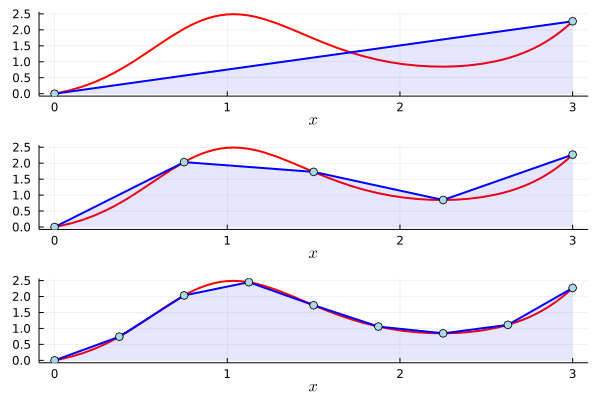

In [3]:
foo(x) = x * exp(sin(2x))
a, b = 0, 3
plt = plot(layout=(3,1), leg=:none, xlabel=L"x")
for (i, n) in enumerate((1, 4, 8))
    x = range(a, b; length=n+1)
    y = foo.(x)
    plot!(foo, a, b; subplot=i,linewidth=2, linecolor=:red)
    plot!(x, y; subplot=i, fill=(0, 0.1, :blue), linecolor=:blue, linewidth=2)
    scatter!(x, y; subplot=i, marker=:o, markercolor=:lightblue)
end
plt

```{raw} html
</div>
```

Для составной формулы трапеций можно показать {cite}`SamarskiyGulin1989`, что

```{math}
|I - T_f| \le \frac{h^2(b-a)}{12} \max_{x\in[a,b]} f''(x) \sim O(h^2).
```

Таким образом, она обладает вторым порядком точности, как и формула прямоугольников. И также точно приближает интеграл от линейной функции.

(sec:quadrature_simpson)=
## Формула Симпсона

Формулу Симпсона несложно получить, решив {eq}`NewtonCotesGeneral` для $x_1 = 0, x_2 = 1/2, x_3 = 1$, 
что соответствует интерполяции $f(x)$ параболой по трём точкам.
Однако можно взглянуть на вывод этой формулы с другой стороны, на основе экстраполяции Ричардсона.

Для формулы трапеций на основе разложения Тейлора можно показать, что

```{math}
:label: simp_step1

I = T_f(h) + c_1 h^2 + O(h^4),
```

где $c_1$ не зависит от $h$.

Если мы проведём расчёт на сетке вдвое мельче, то получим

```{math}
:label: simp_step2

I = T_f(h/2) + c_1 \left(\frac{h}{2}\right)^2 + O(h^4).
```

Комбинируя выражения {eq}`simp_step1` и {eq}`simp_step2` так, чтобы исключить главный член погрешности $c_1 h^2$, получим

```{math}
:label: simp_bigo
I = \frac{1}{3} \big[4 T_f(h/2) - T_f(h)\big] + O(h^4).
```

Таким образом получена уточнённая оценка интеграла. Если сумма $T_f(h)$ вычислена для $h = b - a$, то
```{index} формула; Симпсона
```
```{math}
:label: simp_final
\begin{split}
S_f(h) &= \frac{1}{3} \big[4 T_f\left(\frac{h}{2}\right) - T_f(h)\big] \\
&= \frac{1}{3} \left[
4 \left(\frac{\tilde{f}(0)}{2} + \tilde{f}\left(\frac{h}{2}\right) + \frac{\tilde{f}(h)}{2}\right)\frac{h}{2} - 
h\frac{\tilde{f}(0) + \tilde{f}(h)}{2}
\right] \\
&= \frac{h}{6} \big[ \tilde{f}(0) + 4 \tilde{f}\left(\frac{h}{2}\right) + \tilde{f}(h)\big],
\end{split}
```

где введено обозначение

```{math}
\tilde{f}(x) = f(a + x).
```

Веса в {eq}`simp_final` в точности совпадают с решением {eq}`NewtonCotesGeneral` для $x_1 = 0, x_2 = 1/2, x_3 = 1$. 
Полученное приближение называется **квадратурной формулой Симпсона** (*Simpson's rule*). Из вывода {eq}`simp_step1`--{eq}`simp_bigo` видно, 
что она имеет чётвертый порядок сходимости. Более точная оценка {cite}`SamarskiyGulin1989`

```{math}
|I - S_f(h)| \le \frac{h^4 (b-a)}{2880} \sup_{x\in [a,b]} f^{IV}(x) \sim O(h^4).
```

Отсюда видно, что формула Симпсона приближает точно интеграл от многочленов степени не выше третьей.
```{index} формула; Симпсона (составная)
```
Приведём также явный вид **составной формулы Симпсона**

```{margin}
Можно избавиться от дробных индексов, если ввести сетку $x_i = a_i + 0.5 h i$, $i=0,..,2n$.
```
```{math}
\begin{align}
\int_a^b f(x) \diff x \approx S_f(h) &= \sum\limits_{i=1}^{n} \frac{h}{6}(f_{i-1} + 4 f_{i-1/2} + f_i) \\
&= \frac{h}{6}\big[f_0 + f_n + 2 (f_1 + f_2 + ... + f_{n-1}) + 4 (f_{1/2} + f_{3/2} + ... + f_{n-1/2}) \big].
\end{align}
```

Ниже дана реализация на основе {numref}`Функции {number} <function-trapezoid>`.

:::{proof:function} simpson

**Формула Симпсона**

```julia
"""
Вычисляет по формуле Симпсона интеграл ∫`f`dx на отрезке [`a`, `b`]
с равномерной сеткой из `n` (чётное) интервалов.
Возвращает значение интеграла.
"""
function simpson(f, a, b, n)
    return (1/3) * (4*trapezoid(f, a, b, n) - trapezoid(f, a, b, n÷2))
end
```
:::

:::{proof:demo}
:::
```{raw} html
<div class="demo">
```
**Сравнение формул**

Ниже представлены графики численного интеграла

```{math}
\int_0^3 x e^{\sin 2x}
```

в зависимости от числа интервалов $n$ для разных формул.

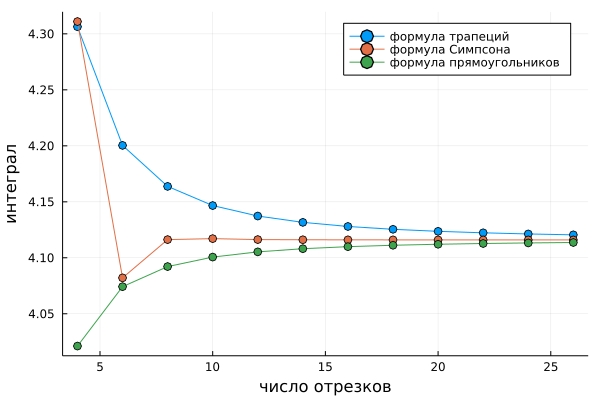

In [4]:
foo(x) = x * exp(sin(2x))
a, b = 0, 3
simp(n) = simpson(foo, a, b, n)
trap(n) = trapezoid(foo, a, b, n)
midp(n) = midpoint(foo, a, b, n)
n = 4:2:26
plot(n, trap.(n); marker=:o, label="формула трапеций", xlabel="число отрезков", ylabel="интеграл")
plot!(n, simp.(n); marker=:o, label="формула Симпсона")
plot!(n, midp.(n); marker=:o, label="формула прямоугольников")

```{raw} html
</div>
```

## Упражения

1. Ниже приведена заготовка функции, находящей узлы и коэффициенты формулы Ньютона-Котса, точной для многочлена степени $p$.
    Заполните пропуски `⟨...⟩`

    ```{code-block} julia
    :emphasize-lines: 8,10,12

    """
    Находит узлы и веса формулы Ньютона-Котса с числом узлов `nnodes` на отрезке `[0; 1]`.
    Если аргумент `closed=true` (по умолчанию), то расчет делается для 
    закрытых квадратурных формул, иначе - для открытых
    """
    function newton_cotes_nodes_weights(nnodes::Integer; closed::Bool=true)
        if closed
            nodes = range(⟨...⟩)
        else
            nodes = range(⟨...⟩)
        end
        rhp = ⟨...⟩
        w = (vandermonde(nodes))' \ rhp
        return (nodes=nodes, weights=w)
    end
    ```